In [1]:
# 載入需要的模組
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# 載入資料；train.csv、test.csv
# 資料來源：https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
train_url = "train.csv"
test_url = "test.csv"
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

In [3]:
# 看看資料長什麼樣子
print('train: ', train.shape)
print('test: ', test.shape)

train:  (1460, 81)
test:  (1459, 80)


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# 合併資料，待會需做處理
all_data = pd.concat([train.loc[:, 'MSSubClass':'SaleCondition'],
                     test.loc[:, 'MSSubClass':'SaleCondition']],
                     axis = 0)
all_data.shape

(2919, 79)

In [7]:
# MSSubClass~SaleCondition共79 個變數()中，有 25 個整數型別、11 個浮點數型別與 43 個文字型別
np.unique(all_data.dtypes.values, return_counts = True)

(array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object),
 array([25, 11, 43], dtype=int64))

In [8]:
# 以及很多null
all_data.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1420
GarageType        157
GarageYrBlt       159
GarageFinish      159
GarageCars          1
GarageArea          1
GarageQual        159
GarageCond

In [9]:
# 整理出具有遺失值的變數列表
total_missing = all_data.isnull().sum().sort_values(ascending=False)
missing_percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, missing_percent], axis = 1, keys = ['Total Missing', 'Missing Percent'])
missing_data.head(20)

,Total Missing,Missing Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [10]:
# 刪除遺失比例過高的變數（Top 5）
all_data = all_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1)

# Log Transform（* 重要的特徵工程）
train["SalePrice"] = np.log1p(train["SalePrice"])

# 轉換類別型變數為數值（One-hot encoding）
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 將遺失值以中位數填補
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [11]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.median())
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [12]:
# 資料乾淨多了
all_data.isnull().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
YearBuilt                0
YearRemodAdd             0
MasVnrArea               0
BsmtFinSF1               0
BsmtFinSF2               0
BsmtUnfSF                0
TotalBsmtSF              0
1stFlrSF                 0
2ndFlrSF                 0
LowQualFinSF             0
GrLivArea                0
BsmtFullBath             0
BsmtHalfBath             0
FullBath                 0
HalfBath                 0
BedroomAbvGr             0
KitchenAbvGr             0
TotRmsAbvGrd             0
Fireplaces               0
GarageYrBlt              0
GarageCars               0
GarageArea               0
WoodDeckSF               0
OpenPorchSF              0
EnclosedPorch            0
                        ..
GarageFinish_RFn         0
GarageFinish_Unf         0
GarageQual_Ex            0
GarageQual_Fa            0
GarageQual_Gd            0
GarageQual_Po            0
G

In [13]:
# 整理模型的輸入
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice

In [14]:
# 回歸模型有四種：Linear Regression、Ridge、Lasso、ElasticNet
# 選擇方根均差(RMSE)最小者
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()
models = [lr, ridge, lasso, elasticnet]
model_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net"]

def get_rmse(model):
    mse = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

for model_name, model in zip(model_names, models):
    print("%s: %f" % (model_name, get_rmse(model)))

Linear Regression: 0.132631
Ridge: 0.126254
Lasso: 0.267405
Elastic Net: 0.263622


In [15]:
# 在 Ridge 中尋找合適的 alpha
# get_rmse_with_alpha
def get_rmse_with_alpha(alpha):
    ridge = Ridge(alpha = alpha)
    mse = cross_val_score(ridge, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

# 納入 alpha 參數
ridge_alphas = np.arange(1, 50, step = 1)
ridge_rmse_cv = []
for i in range(len(ridge_alphas)):
    ridge_rmse_cv.append(get_rmse_with_alpha(ridge_alphas[i]))

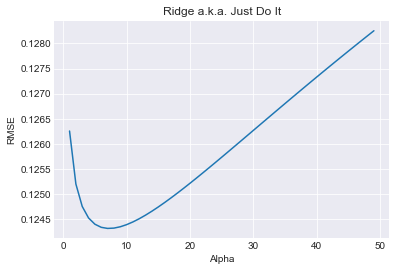

In [16]:
# 作圖
sns.set_style("darkgrid")
plt.plot(ridge_alphas, ridge_rmse_cv)
plt.title("Ridge a.k.a. Just Do It")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.show()

In [17]:
min_rmse_cv = np.min(ridge_rmse_cv)
bool_arr = np.array(ridge_rmse_cv) == min_rmse_cv
ridge_alphas[bool_arr]

array([7])

In [18]:
# 輸出成csv
# 需要好好複習一下統計orz
ridge = Ridge(alpha = ridge_alphas[bool_arr])
ridge.fit(X_train, y_train)
y_hat = ridge.predict(X_test)
y_hat = np.expm1(y_hat)
Id = test.Id
my_solution = pd.DataFrame(y_hat, Id, columns = ["SalePrice"])
my_solution.to_csv("my_solution.csv", index_label = ["Id"])